In [198]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision

from utils import *
from mnist_train import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
import sys
sys.path.append("../")
from Functions import *

In [200]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module

class SimpleNet(Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        inp_dim = 1 #30
        out_dim = 1
        width = 258
        num_layers = 4
        self.fc1 = nn.Linear(inp_dim, width)
        self.layers = [nn.Linear(width, width) for _ in range(num_layers)]
        self.fc2 = nn.Linear(width, out_dim)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        for i in range(len(self.layers)):
            x = F.relu(self.layers[i](x))
        x = self.fc2(x)
        return x

In [201]:
g_params = [[-10, 1, -2], [0, 10, -1]]

f = gaussian_sum(g_params)

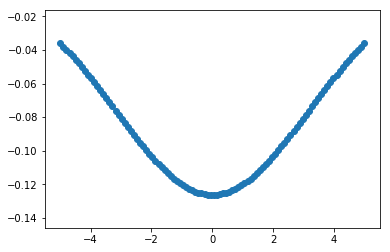

In [202]:
X = np.linspace(-5, 5, 100)
out = f(np.array([X.T]))

plt.scatter(X, out)
plt.show()

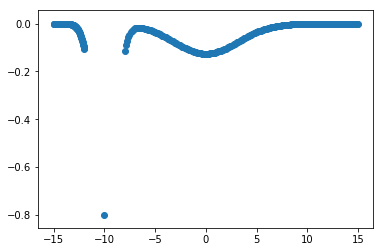

In [222]:
X = np.concatenate([np.array([-10]), np.linspace(-15, -12, 100), np.linspace(-8, 15, 200)])
out = f(np.array([X.T]))

plt.scatter(X, out)
plt.show()

In [215]:
from torch.utils.data import Dataset, DataLoader

class SimpleData(Dataset):
    def __init__(self, X, Y):
        self.data = []
        self.targets = []

        for i in range(len(X)):
            self.data.append(torch.Tensor([X[i]]).float())
            self.targets.append(torch.Tensor([Y[i]]).float())

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)


def get_data(config):
    g_params = [[-10, 1, -2], [0, 10, -1]]
    f = gaussian_sum(g_params)   
    
#     X = np.concatenate([np.array([-10]), np.linspace(-15, 15, 1000), np.linspace(-8, 15, 200)])
    X = np.linspace(-15, 15, 1000)
    out = f(np.array([X.T]))
    data = SimpleData(X, out)
    return DataLoader(data, batch_size=config["batch_size"]["train_size"], shuffle=True), _

In [220]:
config = {
    "torch_random_seed": None, 
    "batch_size": {"train_size": 16, "test_size": 1000},
    
    "num_epochs":  1000, 
    
    "SGD_params": {"learning_rate": 0.1, "momentum": 0},
    "num_nets": 1, # would like to make it like other one, where we can define region to initialize
    "ess_threshold": 0.90, # resample if kish less than this
    
    "softmax_beta": -40, # negtive to prioritize low weights
    
    "weight_type": "loss_gradient_weights"#"input_output_forbenius",
    
}

In [217]:
def train(config):
    # init torch
    torch.backends.cudnn.enabled = False
#     if config["torch_random_seed"] is not None:
#         torch.manual_seed(config["torch_random_seed"])

    # get data
    train_loader, test_loader = get_data(config)

    # Init neural nets and weights
    num_nets = config["num_nets"]
    nets = [SimpleNet() for _ in range(num_nets)]

    #  Define a Loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizers = [optim.SGD(nets[i].parameters(), lr=config["SGD_params"]["learning_rate"],
                            momentum=config["SGD_params"]["momentum"]) for i in range(num_nets)]

#     writer = SummaryWriter()

    # get train loaders for each net
    net_data_loaders = [iter(enumerate(train_loader, 0)) for _ in range(num_nets)]

    # train
    for epoch in range(config["num_epochs"]):
        is_training_epoch = True

        while is_training_epoch:
            for idx_net in range(num_nets):
                # get net and optimizer
                net = nets[idx_net]
                optimizer = optimizers[idx_net]

                # get the inputs; data is a list of [inputs, labels]
                try:
                    i, data = next(net_data_loaders[idx_net])
                except:
                    is_training_epoch = False
                    break
                inputs, labels = data
                labels = labels.reshape(len(labels))
                
#                 # Compute gradients for input.
#                 inputs.requires_grad = True

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward(retain_graph=True)
                optimizer.step()

                # store training accuracy current
#                 writer.add_scalar('Loss/train/net {}'.format(idx_net), loss, i + epoch*len(train_loader))

#                 writer.add_scalar('Weight/net {}'.format(idx_net), curr_weight, i + epoch*len(train_loader))
        net_data_loaders = [iter(enumerate(train_loader, 0)) for _ in range(num_nets)]
        if epoch % 100 == 0:
            print("Epoch {}".format(epoch))
            X = np.linspace(-15, 15, 500)
            Y = nets[0](torch.Tensor(X).view(len(X), 1)).detach().numpy()

            plt.plot(X, Y)
            plt.show()

    return nets
 

Epoch 0


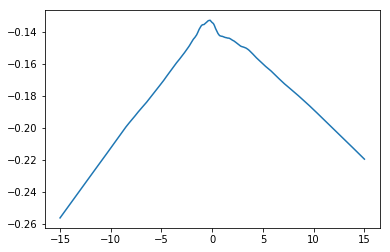

Epoch 100


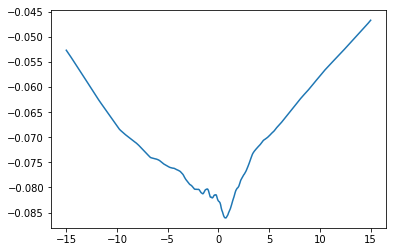

Epoch 200


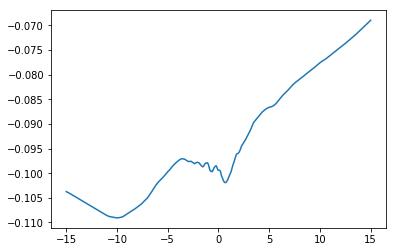

Epoch 300


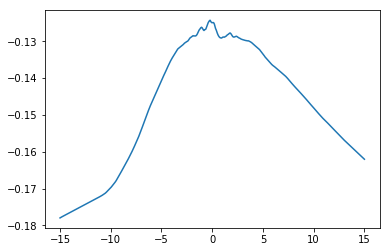

Epoch 400


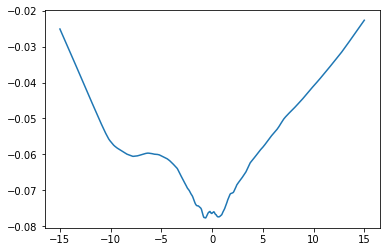

Epoch 500


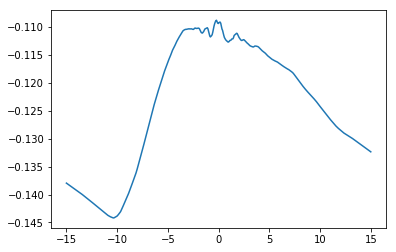

Epoch 600


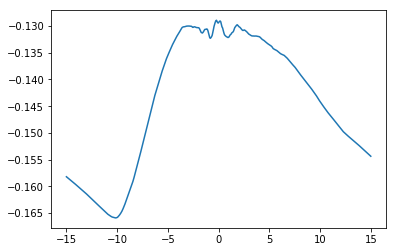

Epoch 700


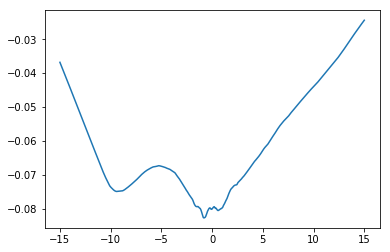

Epoch 800


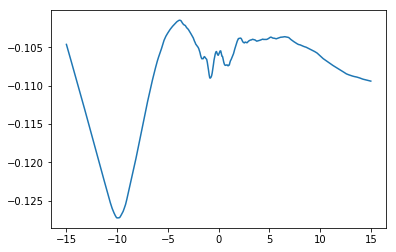

Epoch 900


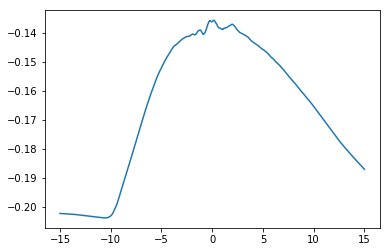

In [221]:
nets = train(config)

(500,)


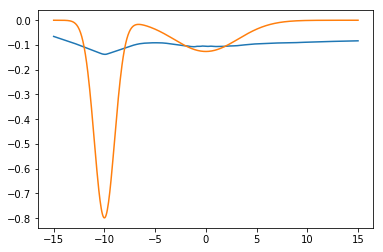

In [197]:
X = np.linspace(-15, 15, 500)
Y = nets[0](torch.Tensor(X).view(len(X), 1)).detach().numpy()

plt.plot(X, Y)
Yp = f(np.array([X.T]))
print(Yp.shape)
plt.plot(X, f(np.array([X.T])))
plt.show()

In [192]:
nets[0](torch.Tensor([2]))

tensor([-0.1049], grad_fn=<AddBackward0>)